In [61]:
import numpy as np
from scipy.fftpack import fft, ifft
from scipy.stats import skew, kurtosis, moment

import numpy as np
from scipy.stats import skew, kurtosis, moment
from scipy.fft import fft, ifft

# Assuming 'x' and 'Fbe' are already defined, and 'Fs' is the sampling frequency
# Make sure 'x' is a numpy array (e.g., x = np.array([...]))

def loychikSD_NP(x, Fs, Fbe):
    # Frequency bin centers
    F = Fbe[:-1] + np.diff(Fbe)

    X = fft(x)
    t = np.arange(0, len(x)) / Fs  # equivalent to the original t calculation
    dF = 1 / t[-1]
    Ff = np.arange(0, len(x)) * dF

    # Statistical moments
    M = np.array([
        np.mean(x),
        np.var(x),
        skew(x),
        kurtosis(x),
        moment(x, 1),
        moment(x, 2),
        moment(x, 3)
    ])

    # Initialize result arrays
    Gx = np.zeros(len(F))
    Sx = np.zeros(len(F))
    Kx = np.zeros(len(F))
    M3x = np.zeros(len(F))
    M4x = np.zeros(len(F))

    for ii in range(len(F)):
        print(f"{ii + 1} / {len(F)}")  # Counter to determine where you are in run

        # Begin low-pass filter by zeroing bins
        Xn = np.argmax(Ff >= Fbe[ii + 1])  # find the first index where Ff >= Fbe[ii + 1]

        cutX = X[1:Xn]
        XI = np.zeros_like(X)
        XI[1:Xn] = cutX

        # Flipping and conjugating for symmetry
        XI = np.flipud(XI)
        XI[0:Xn - 1] = np.conj(cutX)
        XI = np.flipud(XI)

        xifft = ifft(XI)

        # Extracting the real part of the inverse FFT result
        real_xifft = np.real(xifft)  # this makes sure you're calculating statistics on real numbers

        # Statistical calculations
        Gx[ii] = np.var(real_xifft)
        Sx[ii] = skew(real_xifft)
        Kx[ii] = kurtosis(real_xifft) + 3
        M3x[ii] = moment(real_xifft, 3)
        M4x[ii] = moment(real_xifft, 4)

    return M, F, Gx, Sx, Kx

# The variables Gx, Sx, Kx, M3x, M4x hold the results and can be used as needed

# def loychikSD_NP(x, Fs, Fbe):
#     # Frequency bin centers
#     F = Fbe[:-1] + np.diff(Fbe)
#     t = np.arange(0, len(x)) / Fs
#     dF = 1 / t[-1]
#     Ff = np.arange(0, len(x)) * dF  # FFT frequency step

#     M = np.array([
#         np.mean(x),
#         np.var(x),
#         skew(x),
#         kurtosis(x),
#         moment(x, 1),
#         moment(x, 2),
#         moment(x, 3),
#     ])

#     # Initialize arrays for storing results
#     Gx = np.zeros(len(F))
#     Sx = np.zeros(len(F))
#     Kx = np.zeros(len(F))
#     M3x = np.zeros(len(F))
#     M4x = np.zeros(len(F))

#     X = fft(x)

#     for ii in range(len(F)):
#         print(f"{ii+1} out of {len(F)}")  # Counter to determine where you are in the run

#         # Find the index where FFT frequency is greater than or equal to Fbe[ii+1]
#         Xn = np.where(Ff >= Fbe[ii + 1])[0][0]

#         # Low-pass filter by zeroing bins
#         cutX = X[1:Xn+1]  # Adjusted here
#         XI = np.zeros(X.shape, dtype=complex)
#         XI[1:Xn+1] = cutX  # Adjusted here

#         # Make code more similar to Python by replacing symmetric tag with complex conjugate
#         XI[1:Xn] = np.conj(cutX[:-1][::-1])  # Adjusted here, assuming we keep the symmetry

#         xifft = ifft(XI)

#         magnitude = np.abs(xifft)
#         Gx[ii] = np.var(magnitude)
#         Sx[ii] = skew(magnitude)
#         Kx[ii] = kurtosis(magnitude)
#         M3x[ii] = moment(magnitude, 3)
#         M4x[ii] = moment(magnitude, 4)
        
#     return M, F, Gx, Sx, Kx


In [59]:
from scipy.signal import butter, filtfilt
from scipy.signal import hann, welch
import numpy as np
import os

from scipy.io import wavfile

instruments = ['cello_margarita_pitch_stability','violin_raquel_pitch_stability','clarinet_pablo_pitch_stability']
# Read audio file
filepath = "/Users/karthikkurella/Downloads/good-sounds/sound_files/flute_almudena_stability/neumann"


In [26]:
filelist = []
filepath = "/Users/karthikkurella/Downloads/good-sounds/sound_files/"
for i in instruments:
    filetemp = filepath+i+'/'+'neumann'
    for filename in os.listdir(filetemp):
        if filename.endswith('.wav'):
            filelist.append(filename)
len(filelist)

256

In [4]:
filelist[:10]

['0010.wav',
 '0004.wav',
 '0005.wav',
 '0011.wav',
 '0007.wav',
 '0013.wav',
 '0012.wav',
 '0006.wav',
 '0002.wav',
 '0016.wav']

In [62]:
audio_data = []

import scipy.io
from scipy.signal import butter, filtfilt
from scipy.signal import hann, welch
import numpy as np

Fs = 2000
Tr = 1000  # Primary variable
dF = 1 / Tr

# explore the data size from 12 to 120 ?

Fbe = np.logspace(np.log10(10), np.log10(6000), 120)  # Placeholder using logspace
filepath = "/Users/karthikkurella/Downloads/good-sounds/sound_files/"

from scipy.io import wavfile

import os
for i,file in enumerate(instruments):
    fp = filepath+''+file+'/neumann/'
    print(fp)
    arr = [fp + x for x in os.listdir(fp) if x.endswith('.wav')]
    print(arr)
    for j,f in enumerate(arr):
        print(f)
        with open(f, 'rb') as wf:
            Fs, audio_data = wavfile.read(wf)
        x3 = audio_data.astype(float)

        M, F, Gx, Sx, Kx = loychikSD_NP(x3, Fs, Fbe)

        # Power Spectral Density
        Gxx = np.gradient(Gx, F)

        # Skewness Spectral Density
        Sxx = np.gradient(Sx, F)

        # Kurtosis Spectral Density
        Kxx = np.gradient(Kx, F)

        # Fourth Central Moment Spectral Density
        # M4xx = np.gradient(Kx * Gx ** 2, F)

        # Clear variables
        # del x, x2, x3

        # Save variables
        # Specify the filename
        output_path = '/Users/karthikkurella/Documents/Audio_mat/'
        filename = f"{file.split('_')[0]}-{j+1}.mat"

        mat_data = {
        "M": M,
        "F": F,
        "Gx": Gx,
        "Sx": Sx,
        "Kx": Kx,
        "Sxx":Sxx,
        "Gxx":Gxx,
        "Kxx":Kxx
        }

        # Save the dictionary into a .mat file
        scipy.io.savemat(output_path+filename, mat_data)

        print(f"Saved {filename}")

/Users/karthikkurella/Downloads/good-sounds/sound_files/cello_margarita_pitch_stability/neumann/
['/Users/karthikkurella/Downloads/good-sounds/sound_files/cello_margarita_pitch_stability/neumann/0010.wav', '/Users/karthikkurella/Downloads/good-sounds/sound_files/cello_margarita_pitch_stability/neumann/0004.wav', '/Users/karthikkurella/Downloads/good-sounds/sound_files/cello_margarita_pitch_stability/neumann/0038.wav', '/Users/karthikkurella/Downloads/good-sounds/sound_files/cello_margarita_pitch_stability/neumann/0039.wav', '/Users/karthikkurella/Downloads/good-sounds/sound_files/cello_margarita_pitch_stability/neumann/0005.wav', '/Users/karthikkurella/Downloads/good-sounds/sound_files/cello_margarita_pitch_stability/neumann/0011.wav', '/Users/karthikkurella/Downloads/good-sounds/sound_files/cello_margarita_pitch_stability/neumann/0007.wav', '/Users/karthikkurella/Downloads/good-sounds/sound_files/cello_margarita_pitch_stability/neumann/0013.wav', '/Users/karthikkurella/Downloads/good-

/var/folders/g8/ryts82jd3c33vl83y_np4dzm0000gn/T/ipykernel_48677/2393177961.py:28: WavFileWarning: Chunk (non-data) not understood, skipping it.
  Fs, audio_data = wavfile.read(wf)


10 / 119
11 / 119
12 / 119
13 / 119
14 / 119
15 / 119
16 / 119
17 / 119
18 / 119
19 / 119
20 / 119
21 / 119
22 / 119
23 / 119
24 / 119
25 / 119
26 / 119
27 / 119
28 / 119
29 / 119
30 / 119
31 / 119
32 / 119
33 / 119
34 / 119
35 / 119
36 / 119
37 / 119
38 / 119
39 / 119
40 / 119
41 / 119
42 / 119
43 / 119
44 / 119
45 / 119
46 / 119
47 / 119
48 / 119
49 / 119
50 / 119
51 / 119
52 / 119
53 / 119
54 / 119
55 / 119
56 / 119
57 / 119
58 / 119
59 / 119
60 / 119
61 / 119
62 / 119
63 / 119
64 / 119
65 / 119
66 / 119
67 / 119
68 / 119
69 / 119
70 / 119
71 / 119
72 / 119
73 / 119
74 / 119
75 / 119
76 / 119
77 / 119
78 / 119
79 / 119
80 / 119
81 / 119
82 / 119
83 / 119
84 / 119
85 / 119
86 / 119
87 / 119
88 / 119
89 / 119
90 / 119
91 / 119
92 / 119
93 / 119
94 / 119
95 / 119
96 / 119
97 / 119
98 / 119
99 / 119
100 / 119
101 / 119
102 / 119
103 / 119
104 / 119
105 / 119
106 / 119
107 / 119
108 / 119
109 / 119
110 / 119
111 / 119
112 / 119
113 / 119
114 / 119
115 / 119
116 / 119
117 / 119
118 / 119


1 / 119
2 / 119
3 / 119
4 / 119
5 / 119
6 / 119
7 / 119
8 / 119
9 / 119
10 / 119
11 / 119
12 / 119
13 / 119
14 / 119
15 / 119
16 / 119
17 / 119
18 / 119
19 / 119
20 / 119
21 / 119
22 / 119
23 / 119
24 / 119
25 / 119
26 / 119
27 / 119
28 / 119
29 / 119
30 / 119
31 / 119
32 / 119
33 / 119
34 / 119
35 / 119
36 / 119
37 / 119
38 / 119
39 / 119
40 / 119
41 / 119
42 / 119
43 / 119
44 / 119
45 / 119
46 / 119
47 / 119
48 / 119
49 / 119
50 / 119
51 / 119
52 / 119
53 / 119
54 / 119
55 / 119
56 / 119
57 / 119
58 / 119
59 / 119
60 / 119
61 / 119
62 / 119
63 / 119
64 / 119
65 / 119
66 / 119
67 / 119
68 / 119
69 / 119
70 / 119
71 / 119
72 / 119
73 / 119
74 / 119
75 / 119
76 / 119
77 / 119
78 / 119
79 / 119
80 / 119
81 / 119
82 / 119
83 / 119
84 / 119
85 / 119
86 / 119
87 / 119
88 / 119
89 / 119
90 / 119
91 / 119
92 / 119
93 / 119
94 / 119
95 / 119
96 / 119
97 / 119
98 / 119
99 / 119
100 / 119
101 / 119
102 / 119
103 / 119
104 / 119
105 / 119
106 / 119
107 / 119
108 / 119
109 / 119
110 / 119
111 / 11

116 / 119
117 / 119
118 / 119
119 / 119
Saved cello-14.mat
/Users/karthikkurella/Downloads/good-sounds/sound_files/cello_margarita_pitch_stability/neumann/0029.wav
1 / 119
2 / 119
3 / 119
4 / 119
5 / 119
6 / 119
7 / 119
8 / 119
9 / 119
10 / 119
11 / 119
12 / 119
13 / 119
14 / 119
15 / 119
16 / 119
17 / 119
18 / 119
19 / 119
20 / 119
21 / 119
22 / 119
23 / 119
24 / 119
25 / 119
26 / 119
27 / 119
28 / 119
29 / 119
30 / 119
31 / 119
32 / 119
33 / 119
34 / 119
35 / 119
36 / 119
37 / 119
38 / 119
39 / 119
40 / 119
41 / 119
42 / 119
43 / 119
44 / 119
45 / 119
46 / 119
47 / 119
48 / 119
49 / 119
50 / 119
51 / 119
52 / 119
53 / 119
54 / 119
55 / 119
56 / 119
57 / 119
58 / 119
59 / 119
60 / 119
61 / 119
62 / 119
63 / 119
64 / 119
65 / 119
66 / 119
67 / 119
68 / 119
69 / 119
70 / 119
71 / 119
72 / 119
73 / 119
74 / 119
75 / 119
76 / 119
77 / 119
78 / 119
79 / 119
80 / 119
81 / 119
82 / 119
83 / 119
84 / 119
85 / 119
86 / 119
87 / 119
88 / 119
89 / 119
90 / 119
91 / 119
92 / 119
93 / 119
94 / 119

99 / 119
100 / 119
101 / 119
102 / 119
103 / 119
104 / 119
105 / 119
106 / 119
107 / 119
108 / 119
109 / 119
110 / 119
111 / 119
112 / 119
113 / 119
114 / 119
115 / 119
116 / 119
117 / 119
118 / 119
119 / 119
Saved cello-21.mat
/Users/karthikkurella/Downloads/good-sounds/sound_files/cello_margarita_pitch_stability/neumann/0059.wav
1 / 119
2 / 119
3 / 119
4 / 119
5 / 119
6 / 119
7 / 119
8 / 119
9 / 119
10 / 119
11 / 119
12 / 119
13 / 119
14 / 119
15 / 119
16 / 119
17 / 119
18 / 119
19 / 119
20 / 119
21 / 119
22 / 119
23 / 119
24 / 119
25 / 119
26 / 119
27 / 119
28 / 119
29 / 119
30 / 119
31 / 119
32 / 119
33 / 119
34 / 119
35 / 119
36 / 119
37 / 119
38 / 119
39 / 119
40 / 119
41 / 119
42 / 119
43 / 119
44 / 119
45 / 119
46 / 119
47 / 119
48 / 119
49 / 119
50 / 119
51 / 119
52 / 119
53 / 119
54 / 119
55 / 119
56 / 119
57 / 119
58 / 119
59 / 119
60 / 119
61 / 119
62 / 119
63 / 119
64 / 119
65 / 119
66 / 119
67 / 119
68 / 119
69 / 119
70 / 119
71 / 119
72 / 119
73 / 119
74 / 119
75 / 119
7

75 / 119
76 / 119
77 / 119
78 / 119
79 / 119
80 / 119
81 / 119
82 / 119
83 / 119
84 / 119
85 / 119
86 / 119
87 / 119
88 / 119
89 / 119
90 / 119
91 / 119
92 / 119
93 / 119
94 / 119
95 / 119
96 / 119
97 / 119
98 / 119
99 / 119
100 / 119
101 / 119
102 / 119
103 / 119
104 / 119
105 / 119
106 / 119
107 / 119
108 / 119
109 / 119
110 / 119
111 / 119
112 / 119
113 / 119
114 / 119
115 / 119
116 / 119
117 / 119
118 / 119
119 / 119
Saved cello-28.mat
/Users/karthikkurella/Downloads/good-sounds/sound_files/cello_margarita_pitch_stability/neumann/0047.wav
1 / 119
2 / 119
3 / 119
4 / 119
5 / 119
6 / 119
7 / 119
8 / 119
9 / 119
10 / 119
11 / 119
12 / 119
13 / 119
14 / 119
15 / 119
16 / 119
17 / 119
18 / 119
19 / 119
20 / 119
21 / 119
22 / 119
23 / 119
24 / 119
25 / 119
26 / 119
27 / 119
28 / 119
29 / 119
30 / 119
31 / 119
32 / 119
33 / 119
34 / 119
35 / 119
36 / 119
37 / 119
38 / 119
39 / 119
40 / 119
41 / 119
42 / 119
43 / 119
44 / 119
45 / 119
46 / 119
47 / 119
48 / 119
49 / 119
50 / 119
51 / 119
5

53 / 119
54 / 119
55 / 119
56 / 119
57 / 119
58 / 119
59 / 119
60 / 119
61 / 119
62 / 119
63 / 119
64 / 119
65 / 119
66 / 119
67 / 119
68 / 119
69 / 119
70 / 119
71 / 119
72 / 119
73 / 119
74 / 119
75 / 119
76 / 119
77 / 119
78 / 119
79 / 119
80 / 119
81 / 119
82 / 119
83 / 119
84 / 119
85 / 119
86 / 119
87 / 119
88 / 119
89 / 119
90 / 119
91 / 119
92 / 119
93 / 119
94 / 119
95 / 119
96 / 119
97 / 119
98 / 119
99 / 119
100 / 119
101 / 119
102 / 119
103 / 119
104 / 119
105 / 119
106 / 119
107 / 119
108 / 119
109 / 119
110 / 119
111 / 119
112 / 119
113 / 119
114 / 119
115 / 119
116 / 119
117 / 119
118 / 119
119 / 119
Saved cello-35.mat
/Users/karthikkurella/Downloads/good-sounds/sound_files/cello_margarita_pitch_stability/neumann/0054.wav
1 / 119
2 / 119
3 / 119
4 / 119
5 / 119
6 / 119
7 / 119
8 / 119
9 / 119
10 / 119
11 / 119
12 / 119
13 / 119
14 / 119
15 / 119
16 / 119
17 / 119
18 / 119
19 / 119
20 / 119
21 / 119
22 / 119
23 / 119
24 / 119
25 / 119
26 / 119
27 / 119
28 / 119
29 / 119
3

32 / 119
33 / 119
34 / 119
35 / 119
36 / 119
37 / 119
38 / 119
39 / 119
40 / 119
41 / 119
42 / 119
43 / 119
44 / 119
45 / 119
46 / 119
47 / 119
48 / 119
49 / 119
50 / 119
51 / 119
52 / 119
53 / 119
54 / 119
55 / 119
56 / 119
57 / 119
58 / 119
59 / 119
60 / 119
61 / 119
62 / 119
63 / 119
64 / 119
65 / 119
66 / 119
67 / 119
68 / 119
69 / 119
70 / 119
71 / 119
72 / 119
73 / 119
74 / 119
75 / 119
76 / 119
77 / 119
78 / 119
79 / 119
80 / 119
81 / 119
82 / 119
83 / 119
84 / 119
85 / 119
86 / 119
87 / 119
88 / 119
89 / 119
90 / 119
91 / 119
92 / 119
93 / 119
94 / 119
95 / 119
96 / 119
97 / 119
98 / 119
99 / 119
100 / 119
101 / 119
102 / 119
103 / 119
104 / 119
105 / 119
106 / 119
107 / 119
108 / 119
109 / 119
110 / 119
111 / 119
112 / 119
113 / 119
114 / 119
115 / 119
116 / 119
117 / 119
118 / 119
119 / 119
Saved cello-42.mat
/Users/karthikkurella/Downloads/good-sounds/sound_files/cello_margarita_pitch_stability/neumann/0031.wav
1 / 119
2 / 119
3 / 119
4 / 119
5 / 119
6 / 119
7 / 119
8 / 119


8 / 119
9 / 119
10 / 119
11 / 119
12 / 119
13 / 119
14 / 119
15 / 119
16 / 119
17 / 119
18 / 119
19 / 119
20 / 119
21 / 119
22 / 119
23 / 119
24 / 119
25 / 119
26 / 119
27 / 119
28 / 119
29 / 119
30 / 119
31 / 119
32 / 119
33 / 119
34 / 119
35 / 119
36 / 119
37 / 119
38 / 119
39 / 119
40 / 119
41 / 119
42 / 119
43 / 119
44 / 119
45 / 119
46 / 119
47 / 119
48 / 119
49 / 119
50 / 119
51 / 119
52 / 119
53 / 119
54 / 119
55 / 119
56 / 119
57 / 119
58 / 119
59 / 119
60 / 119
61 / 119
62 / 119
63 / 119
64 / 119
65 / 119
66 / 119
67 / 119
68 / 119
69 / 119
70 / 119
71 / 119
72 / 119
73 / 119
74 / 119
75 / 119
76 / 119
77 / 119
78 / 119
79 / 119
80 / 119
81 / 119
82 / 119
83 / 119
84 / 119
85 / 119
86 / 119
87 / 119
88 / 119
89 / 119
90 / 119
91 / 119
92 / 119
93 / 119
94 / 119
95 / 119
96 / 119
97 / 119
98 / 119
99 / 119
100 / 119
101 / 119
102 / 119
103 / 119
104 / 119
105 / 119
106 / 119
107 / 119
108 / 119
109 / 119
110 / 119
111 / 119
112 / 119
113 / 119
114 / 119
115 / 119
116 / 119
117 

115 / 119
116 / 119
117 / 119
118 / 119
119 / 119
Saved cello-55.mat
/Users/karthikkurella/Downloads/good-sounds/sound_files/cello_margarita_pitch_stability/neumann/0022.wav
1 / 119
2 / 119
3 / 119
4 / 119
5 / 119
6 / 119
7 / 119
8 / 119
9 / 119
10 / 119
11 / 119
12 / 119
13 / 119
14 / 119
15 / 119
16 / 119
17 / 119
18 / 119
19 / 119
20 / 119
21 / 119
22 / 119
23 / 119
24 / 119
25 / 119
26 / 119
27 / 119
28 / 119
29 / 119
30 / 119
31 / 119
32 / 119
33 / 119
34 / 119
35 / 119
36 / 119
37 / 119
38 / 119
39 / 119
40 / 119
41 / 119
42 / 119
43 / 119
44 / 119
45 / 119
46 / 119
47 / 119
48 / 119
49 / 119
50 / 119
51 / 119
52 / 119
53 / 119
54 / 119
55 / 119
56 / 119
57 / 119
58 / 119
59 / 119
60 / 119
61 / 119
62 / 119
63 / 119
64 / 119
65 / 119
66 / 119
67 / 119
68 / 119
69 / 119
70 / 119
71 / 119
72 / 119
73 / 119
74 / 119
75 / 119
76 / 119
77 / 119
78 / 119
79 / 119
80 / 119
81 / 119
82 / 119
83 / 119
84 / 119
85 / 119
86 / 119
87 / 119
88 / 119
89 / 119
90 / 119
91 / 119
92 / 119
93 / 11

92 / 119
93 / 119
94 / 119
95 / 119
96 / 119
97 / 119
98 / 119
99 / 119
100 / 119
101 / 119
102 / 119
103 / 119
104 / 119
105 / 119
106 / 119
107 / 119
108 / 119
109 / 119
110 / 119
111 / 119
112 / 119
113 / 119
114 / 119
115 / 119
116 / 119
117 / 119
118 / 119
119 / 119
Saved cello-62.mat
/Users/karthikkurella/Downloads/good-sounds/sound_files/violin_raquel_pitch_stability/neumann/
['/Users/karthikkurella/Downloads/good-sounds/sound_files/violin_raquel_pitch_stability/neumann/0010.wav', '/Users/karthikkurella/Downloads/good-sounds/sound_files/violin_raquel_pitch_stability/neumann/0004.wav', '/Users/karthikkurella/Downloads/good-sounds/sound_files/violin_raquel_pitch_stability/neumann/0038.wav', '/Users/karthikkurella/Downloads/good-sounds/sound_files/violin_raquel_pitch_stability/neumann/0039.wav', '/Users/karthikkurella/Downloads/good-sounds/sound_files/violin_raquel_pitch_stability/neumann/0005.wav', '/Users/karthikkurella/Downloads/good-sounds/sound_files/violin_raquel_pitch_stabil

13 / 119
14 / 119
15 / 119
16 / 119
17 / 119
18 / 119
19 / 119
20 / 119
21 / 119
22 / 119
23 / 119
24 / 119
25 / 119
26 / 119
27 / 119
28 / 119
29 / 119
30 / 119
31 / 119
32 / 119
33 / 119
34 / 119
35 / 119
36 / 119
37 / 119
38 / 119
39 / 119
40 / 119
41 / 119
42 / 119
43 / 119
44 / 119
45 / 119
46 / 119
47 / 119
48 / 119
49 / 119
50 / 119
51 / 119
52 / 119
53 / 119
54 / 119
55 / 119
56 / 119
57 / 119
58 / 119
59 / 119
60 / 119
61 / 119
62 / 119
63 / 119
64 / 119
65 / 119
66 / 119
67 / 119
68 / 119
69 / 119
70 / 119
71 / 119
72 / 119
73 / 119
74 / 119
75 / 119
76 / 119
77 / 119
78 / 119
79 / 119
80 / 119
81 / 119
82 / 119
83 / 119
84 / 119
85 / 119
86 / 119
87 / 119
88 / 119
89 / 119
90 / 119
91 / 119
92 / 119
93 / 119
94 / 119
95 / 119
96 / 119
97 / 119
98 / 119
99 / 119
100 / 119
101 / 119
102 / 119
103 / 119
104 / 119
105 / 119
106 / 119
107 / 119
108 / 119
109 / 119
110 / 119
111 / 119
112 / 119
113 / 119
114 / 119
115 / 119
116 / 119
117 / 119
118 / 119
119 / 119
Saved violin-1.ma

2 / 119
3 / 119
4 / 119
5 / 119
6 / 119
7 / 119
8 / 119
9 / 119
10 / 119
11 / 119
12 / 119
13 / 119
14 / 119
15 / 119
16 / 119
17 / 119
18 / 119
19 / 119
20 / 119
21 / 119
22 / 119
23 / 119
24 / 119
25 / 119
26 / 119
27 / 119
28 / 119
29 / 119
30 / 119
31 / 119
32 / 119
33 / 119
34 / 119
35 / 119
36 / 119
37 / 119
38 / 119
39 / 119
40 / 119
41 / 119
42 / 119
43 / 119
44 / 119
45 / 119
46 / 119
47 / 119
48 / 119
49 / 119
50 / 119
51 / 119
52 / 119
53 / 119
54 / 119
55 / 119
56 / 119
57 / 119
58 / 119
59 / 119
60 / 119
61 / 119
62 / 119
63 / 119
64 / 119
65 / 119
66 / 119
67 / 119
68 / 119
69 / 119
70 / 119
71 / 119
72 / 119
73 / 119
74 / 119
75 / 119
76 / 119
77 / 119
78 / 119
79 / 119
80 / 119
81 / 119
82 / 119
83 / 119
84 / 119
85 / 119
86 / 119
87 / 119
88 / 119
89 / 119
90 / 119
91 / 119
92 / 119
93 / 119
94 / 119
95 / 119
96 / 119
97 / 119
98 / 119
99 / 119
100 / 119
101 / 119
102 / 119
103 / 119
104 / 119
105 / 119
106 / 119
107 / 119
108 / 119
109 / 119
110 / 119
111 / 119
112 / 

113 / 119
114 / 119
115 / 119
116 / 119
117 / 119
118 / 119
119 / 119
Saved violin-14.mat
/Users/karthikkurella/Downloads/good-sounds/sound_files/violin_raquel_pitch_stability/neumann/0029.wav
1 / 119
2 / 119
3 / 119
4 / 119
5 / 119
6 / 119
7 / 119
8 / 119
9 / 119
10 / 119
11 / 119
12 / 119
13 / 119
14 / 119
15 / 119
16 / 119
17 / 119
18 / 119
19 / 119
20 / 119
21 / 119
22 / 119
23 / 119
24 / 119
25 / 119
26 / 119
27 / 119
28 / 119
29 / 119
30 / 119
31 / 119
32 / 119
33 / 119
34 / 119
35 / 119
36 / 119
37 / 119
38 / 119
39 / 119
40 / 119
41 / 119
42 / 119
43 / 119
44 / 119
45 / 119
46 / 119
47 / 119
48 / 119
49 / 119
50 / 119
51 / 119
52 / 119
53 / 119
54 / 119
55 / 119
56 / 119
57 / 119
58 / 119
59 / 119
60 / 119
61 / 119
62 / 119
63 / 119
64 / 119
65 / 119
66 / 119
67 / 119
68 / 119
69 / 119
70 / 119
71 / 119
72 / 119
73 / 119
74 / 119
75 / 119
76 / 119
77 / 119
78 / 119
79 / 119
80 / 119
81 / 119
82 / 119
83 / 119
84 / 119
85 / 119
86 / 119
87 / 119
88 / 119
89 / 119
90 / 119
91 / 1

94 / 119
95 / 119
96 / 119
97 / 119
98 / 119
99 / 119
100 / 119
101 / 119
102 / 119
103 / 119
104 / 119
105 / 119
106 / 119
107 / 119
108 / 119
109 / 119
110 / 119
111 / 119
112 / 119
113 / 119
114 / 119
115 / 119
116 / 119
117 / 119
118 / 119
119 / 119
Saved violin-21.mat
/Users/karthikkurella/Downloads/good-sounds/sound_files/violin_raquel_pitch_stability/neumann/0066.wav
1 / 119
2 / 119
3 / 119
4 / 119
5 / 119
6 / 119
7 / 119
8 / 119
9 / 119
10 / 119
11 / 119
12 / 119
13 / 119
14 / 119
15 / 119
16 / 119
17 / 119
18 / 119
19 / 119
20 / 119
21 / 119
22 / 119
23 / 119
24 / 119
25 / 119
26 / 119
27 / 119
28 / 119
29 / 119
30 / 119
31 / 119
32 / 119
33 / 119
34 / 119
35 / 119
36 / 119
37 / 119
38 / 119
39 / 119
40 / 119
41 / 119
42 / 119
43 / 119
44 / 119
45 / 119
46 / 119
47 / 119
48 / 119
49 / 119
50 / 119
51 / 119
52 / 119
53 / 119
54 / 119
55 / 119
56 / 119
57 / 119
58 / 119
59 / 119
60 / 119
61 / 119
62 / 119
63 / 119
64 / 119
65 / 119
66 / 119
67 / 119
68 / 119
69 / 119
70 / 119
71

72 / 119
73 / 119
74 / 119
75 / 119
76 / 119
77 / 119
78 / 119
79 / 119
80 / 119
81 / 119
82 / 119
83 / 119
84 / 119
85 / 119
86 / 119
87 / 119
88 / 119
89 / 119
90 / 119
91 / 119
92 / 119
93 / 119
94 / 119
95 / 119
96 / 119
97 / 119
98 / 119
99 / 119
100 / 119
101 / 119
102 / 119
103 / 119
104 / 119
105 / 119
106 / 119
107 / 119
108 / 119
109 / 119
110 / 119
111 / 119
112 / 119
113 / 119
114 / 119
115 / 119
116 / 119
117 / 119
118 / 119
119 / 119
Saved violin-28.mat
/Users/karthikkurella/Downloads/good-sounds/sound_files/violin_raquel_pitch_stability/neumann/0049.wav
1 / 119
2 / 119
3 / 119
4 / 119
5 / 119
6 / 119
7 / 119
8 / 119
9 / 119
10 / 119
11 / 119
12 / 119
13 / 119
14 / 119
15 / 119
16 / 119
17 / 119
18 / 119
19 / 119
20 / 119
21 / 119
22 / 119
23 / 119
24 / 119
25 / 119
26 / 119
27 / 119
28 / 119
29 / 119
30 / 119
31 / 119
32 / 119
33 / 119
34 / 119
35 / 119
36 / 119
37 / 119
38 / 119
39 / 119
40 / 119
41 / 119
42 / 119
43 / 119
44 / 119
45 / 119
46 / 119
47 / 119
48 / 119
49

46 / 119
47 / 119
48 / 119
49 / 119
50 / 119
51 / 119
52 / 119
53 / 119
54 / 119
55 / 119
56 / 119
57 / 119
58 / 119
59 / 119
60 / 119
61 / 119
62 / 119
63 / 119
64 / 119
65 / 119
66 / 119
67 / 119
68 / 119
69 / 119
70 / 119
71 / 119
72 / 119
73 / 119
74 / 119
75 / 119
76 / 119
77 / 119
78 / 119
79 / 119
80 / 119
81 / 119
82 / 119
83 / 119
84 / 119
85 / 119
86 / 119
87 / 119
88 / 119
89 / 119
90 / 119
91 / 119
92 / 119
93 / 119
94 / 119
95 / 119
96 / 119
97 / 119
98 / 119
99 / 119
100 / 119
101 / 119
102 / 119
103 / 119
104 / 119
105 / 119
106 / 119
107 / 119
108 / 119
109 / 119
110 / 119
111 / 119
112 / 119
113 / 119
114 / 119
115 / 119
116 / 119
117 / 119
118 / 119
119 / 119
Saved violin-35.mat
/Users/karthikkurella/Downloads/good-sounds/sound_files/violin_raquel_pitch_stability/neumann/0046.wav
1 / 119
2 / 119
3 / 119
4 / 119
5 / 119
6 / 119
7 / 119
8 / 119
9 / 119
10 / 119
11 / 119
12 / 119
13 / 119
14 / 119
15 / 119
16 / 119
17 / 119
18 / 119
19 / 119
20 / 119
21 / 119
22 / 119
23

20 / 119
21 / 119
22 / 119
23 / 119
24 / 119
25 / 119
26 / 119
27 / 119
28 / 119
29 / 119
30 / 119
31 / 119
32 / 119
33 / 119
34 / 119
35 / 119
36 / 119
37 / 119
38 / 119
39 / 119
40 / 119
41 / 119
42 / 119
43 / 119
44 / 119
45 / 119
46 / 119
47 / 119
48 / 119
49 / 119
50 / 119
51 / 119
52 / 119
53 / 119
54 / 119
55 / 119
56 / 119
57 / 119
58 / 119
59 / 119
60 / 119
61 / 119
62 / 119
63 / 119
64 / 119
65 / 119
66 / 119
67 / 119
68 / 119
69 / 119
70 / 119
71 / 119
72 / 119
73 / 119
74 / 119
75 / 119
76 / 119
77 / 119
78 / 119
79 / 119
80 / 119
81 / 119
82 / 119
83 / 119
84 / 119
85 / 119
86 / 119
87 / 119
88 / 119
89 / 119
90 / 119
91 / 119
92 / 119
93 / 119
94 / 119
95 / 119
96 / 119
97 / 119
98 / 119
99 / 119
100 / 119
101 / 119
102 / 119
103 / 119
104 / 119
105 / 119
106 / 119
107 / 119
108 / 119
109 / 119
110 / 119
111 / 119
112 / 119
113 / 119
114 / 119
115 / 119
116 / 119
117 / 119
118 / 119
119 / 119
Saved violin-42.mat
/Users/karthikkurella/Downloads/good-sounds/sound_files/viol

4 / 119
5 / 119
6 / 119
7 / 119
8 / 119
9 / 119
10 / 119
11 / 119
12 / 119
13 / 119
14 / 119
15 / 119
16 / 119
17 / 119
18 / 119
19 / 119
20 / 119
21 / 119
22 / 119
23 / 119
24 / 119
25 / 119
26 / 119
27 / 119
28 / 119
29 / 119
30 / 119
31 / 119
32 / 119
33 / 119
34 / 119
35 / 119
36 / 119
37 / 119
38 / 119
39 / 119
40 / 119
41 / 119
42 / 119
43 / 119
44 / 119
45 / 119
46 / 119
47 / 119
48 / 119
49 / 119
50 / 119
51 / 119
52 / 119
53 / 119
54 / 119
55 / 119
56 / 119
57 / 119
58 / 119
59 / 119
60 / 119
61 / 119
62 / 119
63 / 119
64 / 119
65 / 119
66 / 119
67 / 119
68 / 119
69 / 119
70 / 119
71 / 119
72 / 119
73 / 119
74 / 119
75 / 119
76 / 119
77 / 119
78 / 119
79 / 119
80 / 119
81 / 119
82 / 119
83 / 119
84 / 119
85 / 119
86 / 119
87 / 119
88 / 119
89 / 119
90 / 119
91 / 119
92 / 119
93 / 119
94 / 119
95 / 119
96 / 119
97 / 119
98 / 119
99 / 119
100 / 119
101 / 119
102 / 119
103 / 119
104 / 119
105 / 119
106 / 119
107 / 119
108 / 119
109 / 119
110 / 119
111 / 119
112 / 119
113 / 119
11

114 / 119
115 / 119
116 / 119
117 / 119
118 / 119
119 / 119
Saved violin-55.mat
/Users/karthikkurella/Downloads/good-sounds/sound_files/violin_raquel_pitch_stability/neumann/0018.wav
1 / 119
2 / 119
3 / 119
4 / 119
5 / 119
6 / 119
7 / 119
8 / 119
9 / 119
10 / 119
11 / 119
12 / 119
13 / 119
14 / 119
15 / 119
16 / 119
17 / 119
18 / 119
19 / 119
20 / 119
21 / 119
22 / 119
23 / 119
24 / 119
25 / 119
26 / 119
27 / 119
28 / 119
29 / 119
30 / 119
31 / 119
32 / 119
33 / 119
34 / 119
35 / 119
36 / 119
37 / 119
38 / 119
39 / 119
40 / 119
41 / 119
42 / 119
43 / 119
44 / 119
45 / 119
46 / 119
47 / 119
48 / 119
49 / 119
50 / 119
51 / 119
52 / 119
53 / 119
54 / 119
55 / 119
56 / 119
57 / 119
58 / 119
59 / 119
60 / 119
61 / 119
62 / 119
63 / 119
64 / 119
65 / 119
66 / 119
67 / 119
68 / 119
69 / 119
70 / 119
71 / 119
72 / 119
73 / 119
74 / 119
75 / 119
76 / 119
77 / 119
78 / 119
79 / 119
80 / 119
81 / 119
82 / 119
83 / 119
84 / 119
85 / 119
86 / 119
87 / 119
88 / 119
89 / 119
90 / 119
91 / 119
92 / 11

95 / 119
96 / 119
97 / 119
98 / 119
99 / 119
100 / 119
101 / 119
102 / 119
103 / 119
104 / 119
105 / 119
106 / 119
107 / 119
108 / 119
109 / 119
110 / 119
111 / 119
112 / 119
113 / 119
114 / 119
115 / 119
116 / 119
117 / 119
118 / 119
119 / 119
Saved violin-62.mat
/Users/karthikkurella/Downloads/good-sounds/sound_files/violin_raquel_pitch_stability/neumann/0023.wav
1 / 119
2 / 119
3 / 119
4 / 119
5 / 119
6 / 119
7 / 119
8 / 119
9 / 119
10 / 119
11 / 119
12 / 119
13 / 119
14 / 119
15 / 119
16 / 119
17 / 119
18 / 119
19 / 119
20 / 119
21 / 119
22 / 119
23 / 119
24 / 119
25 / 119
26 / 119
27 / 119
28 / 119
29 / 119
30 / 119
31 / 119
32 / 119
33 / 119
34 / 119
35 / 119
36 / 119
37 / 119
38 / 119
39 / 119
40 / 119
41 / 119
42 / 119
43 / 119
44 / 119
45 / 119
46 / 119
47 / 119
48 / 119
49 / 119
50 / 119
51 / 119
52 / 119
53 / 119
54 / 119
55 / 119
56 / 119
57 / 119
58 / 119
59 / 119
60 / 119
61 / 119
62 / 119
63 / 119
64 / 119
65 / 119
66 / 119
67 / 119
68 / 119
69 / 119
70 / 119
71 / 119
72

72 / 119
73 / 119
74 / 119
75 / 119
76 / 119
77 / 119
78 / 119
79 / 119
80 / 119
81 / 119
82 / 119
83 / 119
84 / 119
85 / 119
86 / 119
87 / 119
88 / 119
89 / 119
90 / 119
91 / 119
92 / 119
93 / 119
94 / 119
95 / 119
96 / 119
97 / 119
98 / 119
99 / 119
100 / 119
101 / 119
102 / 119
103 / 119
104 / 119
105 / 119
106 / 119
107 / 119
108 / 119
109 / 119
110 / 119
111 / 119
112 / 119
113 / 119
114 / 119
115 / 119
116 / 119
117 / 119
118 / 119
119 / 119
Saved violin-69.mat
/Users/karthikkurella/Downloads/good-sounds/sound_files/violin_raquel_pitch_stability/neumann/0021.wav
1 / 119
2 / 119
3 / 119
4 / 119
5 / 119
6 / 119
7 / 119
8 / 119
9 / 119
10 / 119
11 / 119
12 / 119
13 / 119
14 / 119
15 / 119
16 / 119
17 / 119
18 / 119
19 / 119
20 / 119
21 / 119
22 / 119
23 / 119
24 / 119
25 / 119
26 / 119
27 / 119
28 / 119
29 / 119
30 / 119
31 / 119
32 / 119
33 / 119
34 / 119
35 / 119
36 / 119
37 / 119
38 / 119
39 / 119
40 / 119
41 / 119
42 / 119
43 / 119
44 / 119
45 / 119
46 / 119
47 / 119
48 / 119
49

4 / 119
5 / 119
6 / 119
7 / 119
8 / 119
9 / 119
10 / 119
11 / 119
12 / 119
13 / 119
14 / 119
15 / 119
16 / 119
17 / 119
18 / 119
19 / 119
20 / 119
21 / 119
22 / 119
23 / 119
24 / 119
25 / 119
26 / 119
27 / 119
28 / 119
29 / 119
30 / 119
31 / 119
32 / 119
33 / 119
34 / 119
35 / 119
36 / 119
37 / 119
38 / 119
39 / 119
40 / 119
41 / 119
42 / 119
43 / 119
44 / 119
45 / 119
46 / 119
47 / 119
48 / 119
49 / 119
50 / 119
51 / 119
52 / 119
53 / 119
54 / 119
55 / 119
56 / 119
57 / 119
58 / 119
59 / 119
60 / 119
61 / 119
62 / 119
63 / 119
64 / 119
65 / 119
66 / 119
67 / 119
68 / 119
69 / 119
70 / 119
71 / 119
72 / 119
73 / 119
74 / 119
75 / 119
76 / 119
77 / 119
78 / 119
79 / 119
80 / 119
81 / 119
82 / 119
83 / 119
84 / 119
85 / 119
86 / 119
87 / 119
88 / 119
89 / 119
90 / 119
91 / 119
92 / 119
93 / 119
94 / 119
95 / 119
96 / 119
97 / 119
98 / 119
99 / 119
100 / 119
101 / 119
102 / 119
103 / 119
104 / 119
105 / 119
106 / 119
107 / 119
108 / 119
109 / 119
110 / 119
111 / 119
112 / 119
113 / 119
11

114 / 119
115 / 119
116 / 119
117 / 119
118 / 119
119 / 119
Saved clarinet-7.mat
/Users/karthikkurella/Downloads/good-sounds/sound_files/clarinet_pablo_pitch_stability/neumann/0013.wav
1 / 119
2 / 119
3 / 119
4 / 119
5 / 119
6 / 119
7 / 119
8 / 119
9 / 119
10 / 119
11 / 119
12 / 119
13 / 119
14 / 119
15 / 119
16 / 119
17 / 119
18 / 119
19 / 119
20 / 119
21 / 119
22 / 119
23 / 119
24 / 119
25 / 119
26 / 119
27 / 119
28 / 119
29 / 119
30 / 119
31 / 119
32 / 119
33 / 119
34 / 119
35 / 119
36 / 119
37 / 119
38 / 119
39 / 119
40 / 119
41 / 119
42 / 119
43 / 119
44 / 119
45 / 119
46 / 119
47 / 119
48 / 119
49 / 119
50 / 119
51 / 119
52 / 119
53 / 119
54 / 119
55 / 119
56 / 119
57 / 119
58 / 119
59 / 119
60 / 119
61 / 119
62 / 119
63 / 119
64 / 119
65 / 119
66 / 119
67 / 119
68 / 119
69 / 119
70 / 119
71 / 119
72 / 119
73 / 119
74 / 119
75 / 119
76 / 119
77 / 119
78 / 119
79 / 119
80 / 119
81 / 119
82 / 119
83 / 119
84 / 119
85 / 119
86 / 119
87 / 119
88 / 119
89 / 119
90 / 119
91 / 119
92 / 

90 / 119
91 / 119
92 / 119
93 / 119
94 / 119
95 / 119
96 / 119
97 / 119
98 / 119
99 / 119
100 / 119
101 / 119
102 / 119
103 / 119
104 / 119
105 / 119
106 / 119
107 / 119
108 / 119
109 / 119
110 / 119
111 / 119
112 / 119
113 / 119
114 / 119
115 / 119
116 / 119
117 / 119
118 / 119
119 / 119
Saved clarinet-14.mat
/Users/karthikkurella/Downloads/good-sounds/sound_files/clarinet_pablo_pitch_stability/neumann/0029.wav
1 / 119
2 / 119
3 / 119
4 / 119
5 / 119
6 / 119
7 / 119
8 / 119
9 / 119
10 / 119
11 / 119
12 / 119
13 / 119
14 / 119
15 / 119
16 / 119
17 / 119
18 / 119
19 / 119
20 / 119
21 / 119
22 / 119
23 / 119
24 / 119
25 / 119
26 / 119
27 / 119
28 / 119
29 / 119
30 / 119
31 / 119
32 / 119
33 / 119
34 / 119
35 / 119
36 / 119
37 / 119
38 / 119
39 / 119
40 / 119
41 / 119
42 / 119
43 / 119
44 / 119
45 / 119
46 / 119
47 / 119
48 / 119
49 / 119
50 / 119
51 / 119
52 / 119
53 / 119
54 / 119
55 / 119
56 / 119
57 / 119
58 / 119
59 / 119
60 / 119
61 / 119
62 / 119
63 / 119
64 / 119
65 / 119
66 / 119

66 / 119
67 / 119
68 / 119
69 / 119
70 / 119
71 / 119
72 / 119
73 / 119
74 / 119
75 / 119
76 / 119
77 / 119
78 / 119
79 / 119
80 / 119
81 / 119
82 / 119
83 / 119
84 / 119
85 / 119
86 / 119
87 / 119
88 / 119
89 / 119
90 / 119
91 / 119
92 / 119
93 / 119
94 / 119
95 / 119
96 / 119
97 / 119
98 / 119
99 / 119
100 / 119
101 / 119
102 / 119
103 / 119
104 / 119
105 / 119
106 / 119
107 / 119
108 / 119
109 / 119
110 / 119
111 / 119
112 / 119
113 / 119
114 / 119
115 / 119
116 / 119
117 / 119
118 / 119
119 / 119
Saved clarinet-21.mat
/Users/karthikkurella/Downloads/good-sounds/sound_files/clarinet_pablo_pitch_stability/neumann/0067.wav
1 / 119
2 / 119
3 / 119
4 / 119
5 / 119
6 / 119
7 / 119
8 / 119
9 / 119
10 / 119
11 / 119
12 / 119
13 / 119
14 / 119
15 / 119
16 / 119
17 / 119
18 / 119
19 / 119
20 / 119
21 / 119
22 / 119
23 / 119
24 / 119
25 / 119
26 / 119
27 / 119
28 / 119
29 / 119
30 / 119
31 / 119
32 / 119
33 / 119
34 / 119
35 / 119
36 / 119
37 / 119
38 / 119
39 / 119
40 / 119
41 / 119
42 / 119

42 / 119
43 / 119
44 / 119
45 / 119
46 / 119
47 / 119
48 / 119
49 / 119
50 / 119
51 / 119
52 / 119
53 / 119
54 / 119
55 / 119
56 / 119
57 / 119
58 / 119
59 / 119
60 / 119
61 / 119
62 / 119
63 / 119
64 / 119
65 / 119
66 / 119
67 / 119
68 / 119
69 / 119
70 / 119
71 / 119
72 / 119
73 / 119
74 / 119
75 / 119
76 / 119
77 / 119
78 / 119
79 / 119
80 / 119
81 / 119
82 / 119
83 / 119
84 / 119
85 / 119
86 / 119
87 / 119
88 / 119
89 / 119
90 / 119
91 / 119
92 / 119
93 / 119
94 / 119
95 / 119
96 / 119
97 / 119
98 / 119
99 / 119
100 / 119
101 / 119
102 / 119
103 / 119
104 / 119
105 / 119
106 / 119
107 / 119
108 / 119
109 / 119
110 / 119
111 / 119
112 / 119
113 / 119
114 / 119
115 / 119
116 / 119
117 / 119
118 / 119
119 / 119
Saved clarinet-28.mat
/Users/karthikkurella/Downloads/good-sounds/sound_files/clarinet_pablo_pitch_stability/neumann/0071.wav
1 / 119
2 / 119
3 / 119
4 / 119
5 / 119
6 / 119
7 / 119
8 / 119
9 / 119
10 / 119
11 / 119
12 / 119
13 / 119
14 / 119
15 / 119
16 / 119
17 / 119
18 / 119

18 / 119
19 / 119
20 / 119
21 / 119
22 / 119
23 / 119
24 / 119
25 / 119
26 / 119
27 / 119
28 / 119
29 / 119
30 / 119
31 / 119
32 / 119
33 / 119
34 / 119
35 / 119
36 / 119
37 / 119
38 / 119
39 / 119
40 / 119
41 / 119
42 / 119
43 / 119
44 / 119
45 / 119
46 / 119
47 / 119
48 / 119
49 / 119
50 / 119
51 / 119
52 / 119
53 / 119
54 / 119
55 / 119
56 / 119
57 / 119
58 / 119
59 / 119
60 / 119
61 / 119
62 / 119
63 / 119
64 / 119
65 / 119
66 / 119
67 / 119
68 / 119
69 / 119
70 / 119
71 / 119
72 / 119
73 / 119
74 / 119
75 / 119
76 / 119
77 / 119
78 / 119
79 / 119
80 / 119
81 / 119
82 / 119
83 / 119
84 / 119
85 / 119
86 / 119
87 / 119
88 / 119
89 / 119
90 / 119
91 / 119
92 / 119
93 / 119
94 / 119
95 / 119
96 / 119
97 / 119
98 / 119
99 / 119
100 / 119
101 / 119
102 / 119
103 / 119
104 / 119
105 / 119
106 / 119
107 / 119
108 / 119
109 / 119
110 / 119
111 / 119
112 / 119
113 / 119
114 / 119
115 / 119
116 / 119
117 / 119
118 / 119
119 / 119
Saved clarinet-35.mat
/Users/karthikkurella/Downloads/good-sou

1 / 119
2 / 119
3 / 119
4 / 119
5 / 119
6 / 119
7 / 119
8 / 119
9 / 119
10 / 119
11 / 119
12 / 119
13 / 119
14 / 119
15 / 119
16 / 119
17 / 119
18 / 119
19 / 119
20 / 119
21 / 119
22 / 119
23 / 119
24 / 119
25 / 119
26 / 119
27 / 119
28 / 119
29 / 119
30 / 119
31 / 119
32 / 119
33 / 119
34 / 119
35 / 119
36 / 119
37 / 119
38 / 119
39 / 119
40 / 119
41 / 119
42 / 119
43 / 119
44 / 119
45 / 119
46 / 119
47 / 119
48 / 119
49 / 119
50 / 119
51 / 119
52 / 119
53 / 119
54 / 119
55 / 119
56 / 119
57 / 119
58 / 119
59 / 119
60 / 119
61 / 119
62 / 119
63 / 119
64 / 119
65 / 119
66 / 119
67 / 119
68 / 119
69 / 119
70 / 119
71 / 119
72 / 119
73 / 119
74 / 119
75 / 119
76 / 119
77 / 119
78 / 119
79 / 119
80 / 119
81 / 119
82 / 119
83 / 119
84 / 119
85 / 119
86 / 119
87 / 119
88 / 119
89 / 119
90 / 119
91 / 119
92 / 119
93 / 119
94 / 119
95 / 119
96 / 119
97 / 119
98 / 119
99 / 119
100 / 119
101 / 119
102 / 119
103 / 119
104 / 119
105 / 119
106 / 119
107 / 119
108 / 119
109 / 119
110 / 119
111 / 11

112 / 119
113 / 119
114 / 119
115 / 119
116 / 119
117 / 119
118 / 119
119 / 119
Saved clarinet-48.mat
/Users/karthikkurella/Downloads/good-sounds/sound_files/clarinet_pablo_pitch_stability/neumann/0053.wav
1 / 119
2 / 119
3 / 119
4 / 119
5 / 119
6 / 119
7 / 119
8 / 119
9 / 119
10 / 119
11 / 119
12 / 119
13 / 119
14 / 119
15 / 119
16 / 119
17 / 119
18 / 119
19 / 119
20 / 119
21 / 119
22 / 119
23 / 119
24 / 119
25 / 119
26 / 119
27 / 119
28 / 119
29 / 119
30 / 119
31 / 119
32 / 119
33 / 119
34 / 119
35 / 119
36 / 119
37 / 119
38 / 119
39 / 119
40 / 119
41 / 119
42 / 119
43 / 119
44 / 119
45 / 119
46 / 119
47 / 119
48 / 119
49 / 119
50 / 119
51 / 119
52 / 119
53 / 119
54 / 119
55 / 119
56 / 119
57 / 119
58 / 119
59 / 119
60 / 119
61 / 119
62 / 119
63 / 119
64 / 119
65 / 119
66 / 119
67 / 119
68 / 119
69 / 119
70 / 119
71 / 119
72 / 119
73 / 119
74 / 119
75 / 119
76 / 119
77 / 119
78 / 119
79 / 119
80 / 119
81 / 119
82 / 119
83 / 119
84 / 119
85 / 119
86 / 119
87 / 119
88 / 119
89 / 119
90

87 / 119
88 / 119
89 / 119
90 / 119
91 / 119
92 / 119
93 / 119
94 / 119
95 / 119
96 / 119
97 / 119
98 / 119
99 / 119
100 / 119
101 / 119
102 / 119
103 / 119
104 / 119
105 / 119
106 / 119
107 / 119
108 / 119
109 / 119
110 / 119
111 / 119
112 / 119
113 / 119
114 / 119
115 / 119
116 / 119
117 / 119
118 / 119
119 / 119
Saved clarinet-55.mat
/Users/karthikkurella/Downloads/good-sounds/sound_files/clarinet_pablo_pitch_stability/neumann/0050.wav
1 / 119
2 / 119
3 / 119
4 / 119
5 / 119
6 / 119
7 / 119
8 / 119
9 / 119
10 / 119
11 / 119
12 / 119
13 / 119
14 / 119
15 / 119
16 / 119
17 / 119
18 / 119
19 / 119
20 / 119
21 / 119
22 / 119
23 / 119
24 / 119
25 / 119
26 / 119
27 / 119
28 / 119
29 / 119
30 / 119
31 / 119
32 / 119
33 / 119
34 / 119
35 / 119
36 / 119
37 / 119
38 / 119
39 / 119
40 / 119
41 / 119
42 / 119
43 / 119
44 / 119
45 / 119
46 / 119
47 / 119
48 / 119
49 / 119
50 / 119
51 / 119
52 / 119
53 / 119
54 / 119
55 / 119
56 / 119
57 / 119
58 / 119
59 / 119
60 / 119
61 / 119
62 / 119
63 / 119

58 / 119
59 / 119
60 / 119
61 / 119
62 / 119
63 / 119
64 / 119
65 / 119
66 / 119
67 / 119
68 / 119
69 / 119
70 / 119
71 / 119
72 / 119
73 / 119
74 / 119
75 / 119
76 / 119
77 / 119
78 / 119
79 / 119
80 / 119
81 / 119
82 / 119
83 / 119
84 / 119
85 / 119
86 / 119
87 / 119
88 / 119
89 / 119
90 / 119
91 / 119
92 / 119
93 / 119
94 / 119
95 / 119
96 / 119
97 / 119
98 / 119
99 / 119
100 / 119
101 / 119
102 / 119
103 / 119
104 / 119
105 / 119
106 / 119
107 / 119
108 / 119
109 / 119
110 / 119
111 / 119
112 / 119
113 / 119
114 / 119
115 / 119
116 / 119
117 / 119
118 / 119
119 / 119
Saved clarinet-62.mat
/Users/karthikkurella/Downloads/good-sounds/sound_files/clarinet_pablo_pitch_stability/neumann/0055.wav
1 / 119
2 / 119
3 / 119
4 / 119
5 / 119
6 / 119
7 / 119
8 / 119
9 / 119
10 / 119
11 / 119
12 / 119
13 / 119
14 / 119
15 / 119
16 / 119
17 / 119
18 / 119
19 / 119
20 / 119
21 / 119
22 / 119
23 / 119
24 / 119
25 / 119
26 / 119
27 / 119
28 / 119
29 / 119
30 / 119
31 / 119
32 / 119
33 / 119
34 / 119

32 / 119
33 / 119
34 / 119
35 / 119
36 / 119
37 / 119
38 / 119
39 / 119
40 / 119
41 / 119
42 / 119
43 / 119
44 / 119
45 / 119
46 / 119
47 / 119
48 / 119
49 / 119
50 / 119
51 / 119
52 / 119
53 / 119
54 / 119
55 / 119
56 / 119
57 / 119
58 / 119
59 / 119
60 / 119
61 / 119
62 / 119
63 / 119
64 / 119
65 / 119
66 / 119
67 / 119
68 / 119
69 / 119
70 / 119
71 / 119
72 / 119
73 / 119
74 / 119
75 / 119
76 / 119
77 / 119
78 / 119
79 / 119
80 / 119
81 / 119
82 / 119
83 / 119
84 / 119
85 / 119
86 / 119
87 / 119
88 / 119
89 / 119
90 / 119
91 / 119
92 / 119
93 / 119
94 / 119
95 / 119
96 / 119
97 / 119
98 / 119
99 / 119
100 / 119
101 / 119
102 / 119
103 / 119
104 / 119
105 / 119
106 / 119
107 / 119
108 / 119
109 / 119
110 / 119
111 / 119
112 / 119
113 / 119
114 / 119
115 / 119
116 / 119
117 / 119
118 / 119
119 / 119
Saved clarinet-69.mat
/Users/karthikkurella/Downloads/good-sounds/sound_files/clarinet_pablo_pitch_stability/neumann/0042.wav
1 / 119
2 / 119
3 / 119
4 / 119
5 / 119
6 / 119
7 / 119
8 / 11

2 / 119
3 / 119
4 / 119
5 / 119
6 / 119
7 / 119
8 / 119
9 / 119
10 / 119
11 / 119
12 / 119
13 / 119
14 / 119
15 / 119
16 / 119
17 / 119
18 / 119
19 / 119
20 / 119
21 / 119
22 / 119
23 / 119
24 / 119
25 / 119
26 / 119
27 / 119
28 / 119
29 / 119
30 / 119
31 / 119
32 / 119
33 / 119
34 / 119
35 / 119
36 / 119
37 / 119
38 / 119
39 / 119
40 / 119
41 / 119
42 / 119
43 / 119
44 / 119
45 / 119
46 / 119
47 / 119
48 / 119
49 / 119
50 / 119
51 / 119
52 / 119
53 / 119
54 / 119
55 / 119
56 / 119
57 / 119
58 / 119
59 / 119
60 / 119
61 / 119
62 / 119
63 / 119
64 / 119
65 / 119
66 / 119
67 / 119
68 / 119
69 / 119
70 / 119
71 / 119
72 / 119
73 / 119
74 / 119
75 / 119
76 / 119
77 / 119
78 / 119
79 / 119
80 / 119
81 / 119
82 / 119
83 / 119
84 / 119
85 / 119
86 / 119
87 / 119
88 / 119
89 / 119
90 / 119
91 / 119
92 / 119
93 / 119
94 / 119
95 / 119
96 / 119
97 / 119
98 / 119
99 / 119
100 / 119
101 / 119
102 / 119
103 / 119
104 / 119
105 / 119
106 / 119
107 / 119
108 / 119
109 / 119
110 / 119
111 / 119
112 / 

114 / 119
115 / 119
116 / 119
117 / 119
118 / 119
119 / 119
Saved clarinet-82.mat
/Users/karthikkurella/Downloads/good-sounds/sound_files/clarinet_pablo_pitch_stability/neumann/0037.wav
1 / 119
2 / 119
3 / 119
4 / 119
5 / 119
6 / 119
7 / 119
8 / 119
9 / 119
10 / 119
11 / 119
12 / 119
13 / 119
14 / 119
15 / 119
16 / 119
17 / 119
18 / 119
19 / 119
20 / 119
21 / 119
22 / 119
23 / 119
24 / 119
25 / 119
26 / 119
27 / 119
28 / 119
29 / 119
30 / 119
31 / 119
32 / 119
33 / 119
34 / 119
35 / 119
36 / 119
37 / 119
38 / 119
39 / 119
40 / 119
41 / 119
42 / 119
43 / 119
44 / 119
45 / 119
46 / 119
47 / 119
48 / 119
49 / 119
50 / 119
51 / 119
52 / 119
53 / 119
54 / 119
55 / 119
56 / 119
57 / 119
58 / 119
59 / 119
60 / 119
61 / 119
62 / 119
63 / 119
64 / 119
65 / 119
66 / 119
67 / 119
68 / 119
69 / 119
70 / 119
71 / 119
72 / 119
73 / 119
74 / 119
75 / 119
76 / 119
77 / 119
78 / 119
79 / 119
80 / 119
81 / 119
82 / 119
83 / 119
84 / 119
85 / 119
86 / 119
87 / 119
88 / 119
89 / 119
90 / 119
91 / 119
92 /

92 / 119
93 / 119
94 / 119
95 / 119
96 / 119
97 / 119
98 / 119
99 / 119
100 / 119
101 / 119
102 / 119
103 / 119
104 / 119
105 / 119
106 / 119
107 / 119
108 / 119
109 / 119
110 / 119
111 / 119
112 / 119
113 / 119
114 / 119
115 / 119
116 / 119
117 / 119
118 / 119
119 / 119
Saved clarinet-89.mat
/Users/karthikkurella/Downloads/good-sounds/sound_files/clarinet_pablo_pitch_stability/neumann/0035.wav
1 / 119
2 / 119
3 / 119
4 / 119
5 / 119
6 / 119
7 / 119
8 / 119
9 / 119
10 / 119
11 / 119
12 / 119
13 / 119
14 / 119
15 / 119
16 / 119
17 / 119
18 / 119
19 / 119
20 / 119
21 / 119
22 / 119
23 / 119
24 / 119
25 / 119
26 / 119
27 / 119
28 / 119
29 / 119
30 / 119
31 / 119
32 / 119
33 / 119
34 / 119
35 / 119
36 / 119
37 / 119
38 / 119
39 / 119
40 / 119
41 / 119
42 / 119
43 / 119
44 / 119
45 / 119
46 / 119
47 / 119
48 / 119
49 / 119
50 / 119
51 / 119
52 / 119
53 / 119
54 / 119
55 / 119
56 / 119
57 / 119
58 / 119
59 / 119
60 / 119
61 / 119
62 / 119
63 / 119
64 / 119
65 / 119
66 / 119
67 / 119
68 / 119

In [28]:
len(Fbe)

120

In [4]:
audio_mat = [] 
filepath = '/Users/karthikkurella/Documents/Audio_mat/'
for filename in os.listdir(filepath):
    if filename.endswith('.mat'):
        audio_mat.append(filename)
audio_mat
print(len(audio_mat))

319


In [5]:
audio_mat[:5]

['cello-16.mat',
 'clarinet-59.mat',
 'clarinet-71.mat',
 'clarinet-65.mat',
 'flute-9.mat']

In [90]:
!pwd

/Users/karthikkurella/Documents/Spectral densities/High-order-spectral-densities/src


In [89]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import scipy.io
import os
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Initialize empty arrays to hold features and labels
features_list = []
labels_list = []
labels = []
# Path to the directory containing .mat files
mat_dir = "/Users/karthikkurella/Documents/Audio_mat"

# Loop through each .mat file
for mat_file in os.listdir(mat_dir):
    if mat_file.endswith('.mat'):
        full_path = os.path.join(mat_dir, mat_file)
        
        # Load the MAT file
        data = scipy.io.loadmat(full_path)

        # Combine descriptors into a feature vector
        # You might want to scale or normalize the features
        #feature = np.column_stack((data['M'], data['Gx'], data['Sx'], data['Kx'])).ravel()
        feature = np.column_stack((data['Gxx'])).ravel()
        
        # Append to the list of features
        features_list.append(feature)
        
        # Dummy labels for now; replace with actual labels if available
#         labels_list.append(np.random.randint(2))
        print(full_path.split('/')[-1].split('-')[0])
        labels_list.append(full_path.split('/')[-1].split('-')[0])
        #print(full_path)

features = np.array(features_list,dtype=object)
labels = np.array(labels_list)

cello
clarinet
clarinet
clarinet
violin
violin
violin
violin
clarinet
clarinet
cello
clarinet
cello
clarinet
cello
clarinet
violin
violin
violin
violin
violin
violin
clarinet
clarinet
cello
cello
clarinet
clarinet
cello
cello
clarinet
violin
violin
violin
violin
clarinet
cello
clarinet
cello
clarinet
clarinet
clarinet
clarinet
cello
violin
violin
violin
violin
cello
clarinet
clarinet
clarinet
cello
clarinet
cello
violin
violin
clarinet
clarinet
violin
violin
cello
clarinet
cello
clarinet
cello
clarinet
violin
violin
violin
clarinet
violin
violin
violin
clarinet
clarinet
clarinet
clarinet
violin
violin
clarinet
clarinet
violin
violin
clarinet
clarinet
clarinet
cello
cello
violin
violin
violin
clarinet
clarinet
violin
violin
violin
cello
clarinet
cello
cello
cello
clarinet
clarinet
violin
cello
violin
violin
violin
violin
cello
violin
clarinet
clarinet
cello
cello
cello
clarinet
cello
clarinet
clarinet
cello
violin
clarinet
clarinet
violin
cello
violin
clarinet
clarinet
cello
cello
clari

In [64]:
print(data['Sx'].shape, data['Kx'].shape)

(1, 119) (1, 119)


In [65]:
len(features_list)

225

In [13]:
feature.shape

(119,)

In [68]:
features.shape

(225, 119)

In [69]:
del label_list

In [66]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)



In [90]:
# Convert lists to NumPy arrays

# Initialize the Random Forest model

clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Standardize the features (z-score normalization)
scaler = StandardScaler()

# Initialize the Random Forest model
clf = RandomForestClassifier(random_state=42)

# Create a pipeline
pipeline = Pipeline([
#     ('scaler', scaler),
    ('classifier', clf)
])

# Hyperparameter grid to search
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Initialize Grid Search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)

# Perform Grid Search on the training data
grid_search.fit(X_train, y_train)

# Best parameters from Grid Search
print("Best Parameters: ", grid_search.best_params_)

# Evaluate the model with best parameters
y_pred = grid_search.predict(X_test)
print(f"Optimized Accuracy: {accuracy_score(y_test, y_pred)}")

Best Parameters:  {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Optimized Accuracy: 0.9111111111111111


In [92]:
# imporatance graph
# Get feature importances
clf = RandomForestClassifier(n_estimators=200, random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Get feature importances
importances = clf.feature_importances_

# Sort the feature importances in descending order and get the indices
indices = np.argsort(importances)[::-1]

# Rearrange your features in the order of importance
features_imp = [f'Feature {i+1}' for i in range(X_train.shape[1])]
sorted_features = [features_imp[i] for i in indices[:10]]



In [93]:
sorted_features

['Feature 41',
 'Feature 110',
 'Feature 116',
 'Feature 111',
 'Feature 113',
 'Feature 52',
 'Feature 46',
 'Feature 115',
 'Feature 112',
 'Feature 117']

(10, 6000)

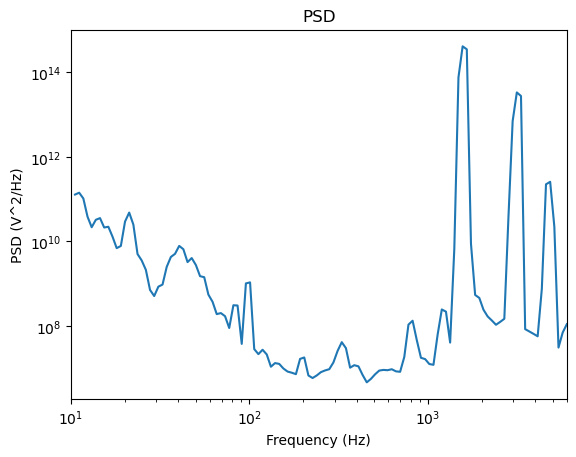

In [94]:
import matplotlib.pyplot as plt
import scipy.io
import numpy as np

plt.figure(3)
plt.loglog(F,data["Gxx"][0], linewidth=1.5)
plt.title('PSD')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.xlim([10, 6000])

In [95]:
data["Gxx"].shape

(1, 119)

## Model breakdown

TypeError: Image data of dtype object cannot be converted to float

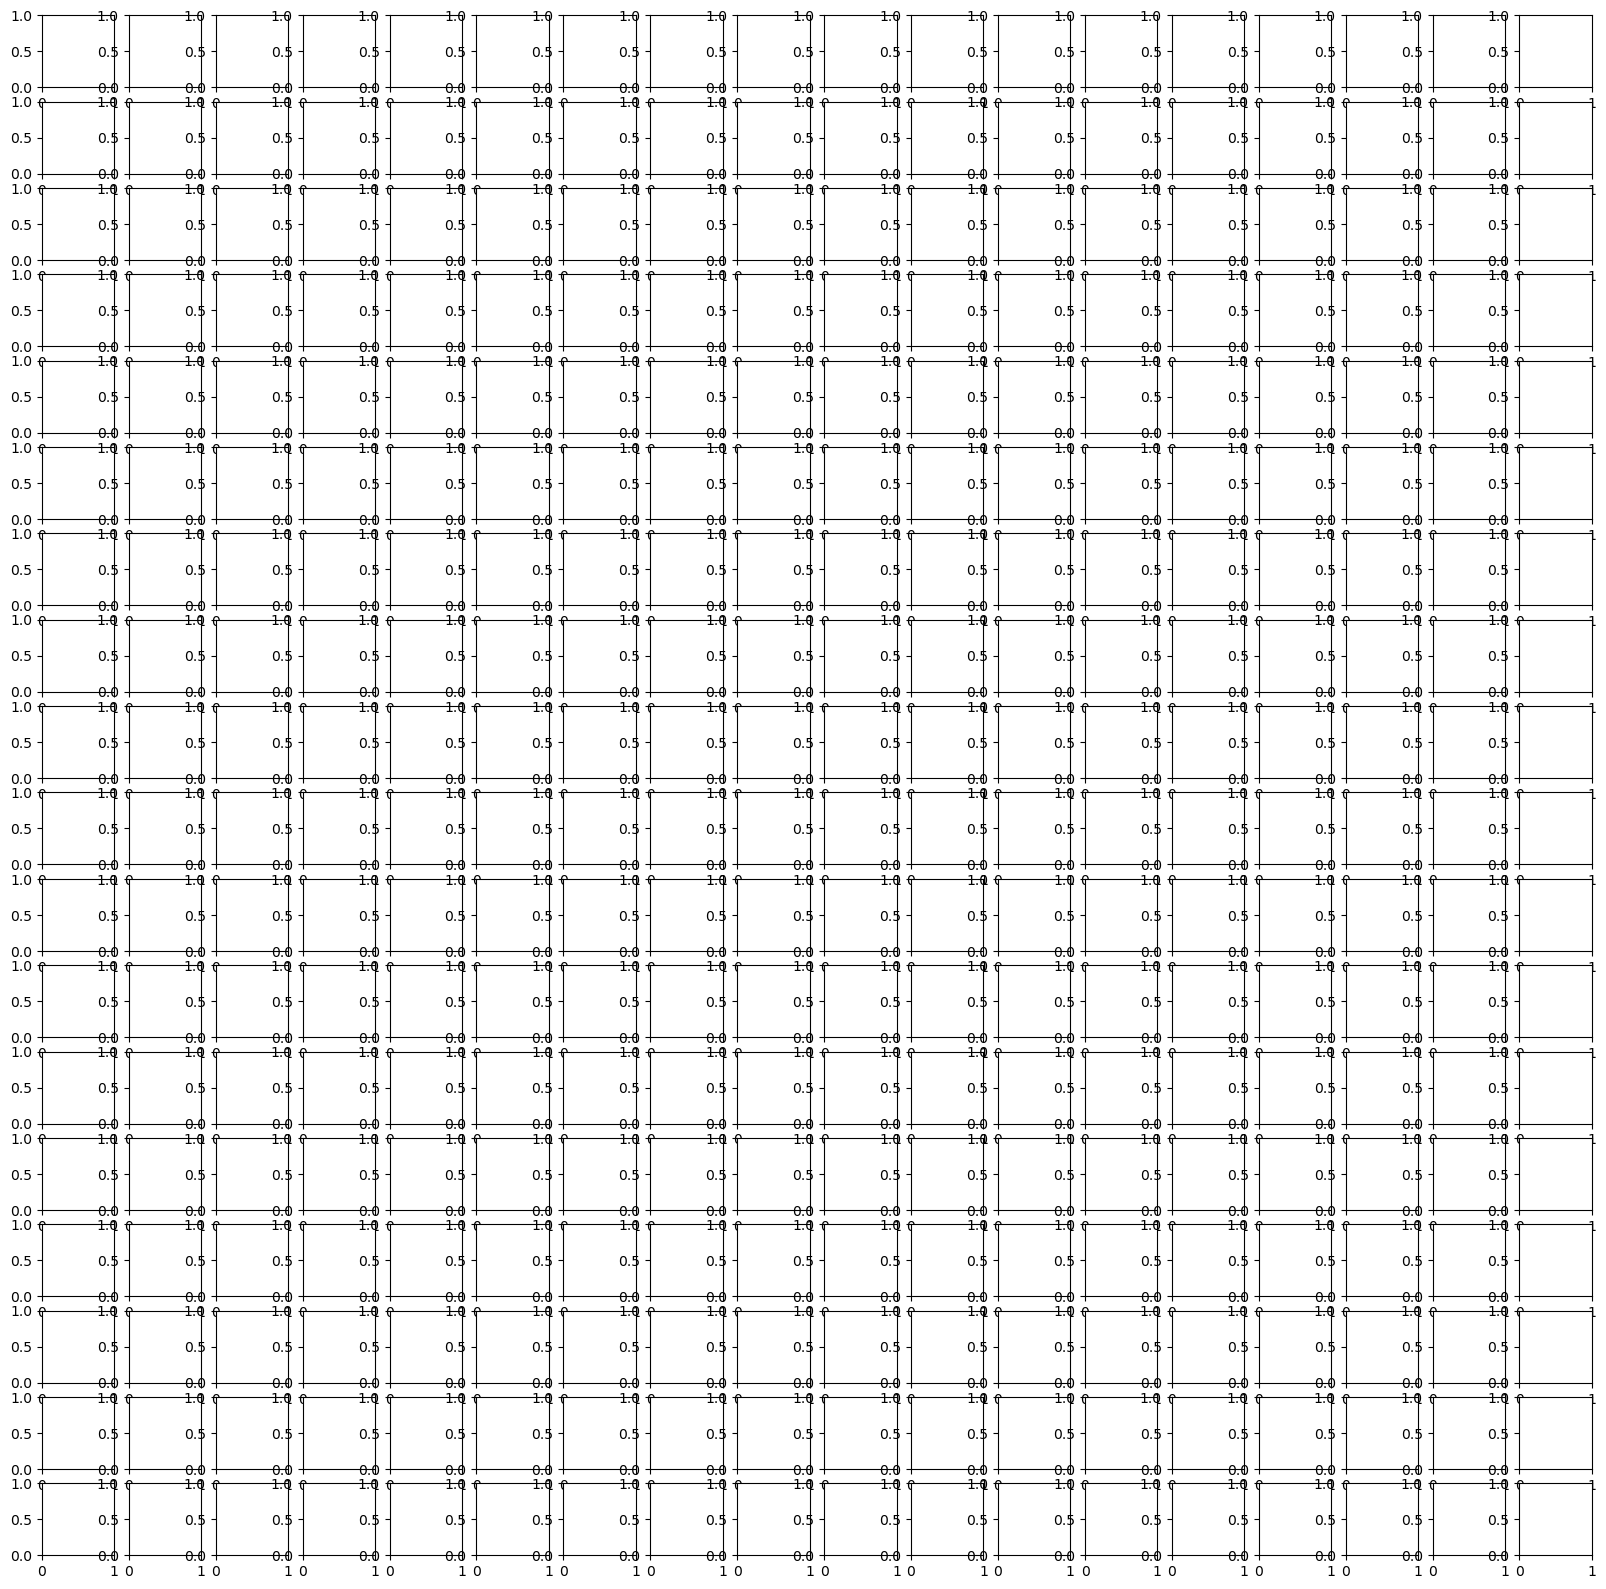

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'features' is already loaded and has a shape of (319, 120)

# Drop the last column if it is not part of the features
features = features[:, :-1]  # This slices all rows and all but the last column

# Calculate the grid size for visualization
grid_size = int(np.ceil(np.sqrt(features.shape[0])))

# Set up the matplotlib figure and axes based on the grid size
fig, axes = plt.subplots(grid_size, grid_size, figsize=(20, 20))

# Flatten the axes array for convenience
axes_flat = axes.flatten()

# Iterate over each feature set and plot it
for i, feature in enumerate(features):
    # Calculate the square size (next perfect square for 119)
    square_size = int(np.ceil(np.sqrt(len(feature))))
    # Pad the feature to make it a perfect square
    padded_feature = np.pad(feature, (0, square_size**2 - len(feature)), 'constant', constant_values=0)
    # Reshape the feature to a square for visualization
    square_feature = padded_feature.reshape(square_size, square_size)
    # Plot the feature
    ax = axes_flat[i]
ax.imshow(square_feature, cmap='viridis')
ax.axis('off')  # Hide the axes ticks

# Remove any unused subplots
for j in range(i + 1, len(axes_flat)):
    fig.delaxes(axes_flat[j])

# Adjust the layout
plt.tight_layout()
plt.show()


In [11]:
features[0].shape

(119,)

array([2.6423271568943613e-05, 0.00021364077642194588,
       0.0008486413566177011, 0.0012343288720749772,
       0.0006597325258861162, -0.00048236207419545264,
       -0.0031255526418644277, -0.003473317722581606,
       -0.0039756069321683785, -0.00333434513511411,
       -0.003170547685015705, -0.0033951419740873546,
       -0.002729213337065474, -0.001190086847289232,
       0.0019197395498045074, 0.003443873350493308, 0.0019561960961207636,
       -0.00014136926746514576, -0.00043740520017465276,
       -0.001319103916345853, -0.0019570018560405487,
       -0.0026499538001386116, -0.0032218942833495802,
       -0.0028236929006466723, -0.003513953876955901,
       -0.004193769369105395, -0.0028604976901127, -0.0010888967488717138,
       -0.001979051427790945, -0.0011388928856068494,
       -0.001319107710529865, -0.002566877697876258,
       -0.0028250586488402806, -0.0028008494573283508,
       -0.0033493079623043045, -0.003301431161487753,
       -0.0035997967179405847, -0.003

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import numpy as np

# Predict probabilities
prob_predictions = grid_search.predict_proba(X_test)

# Calculate log loss
loss = log_loss(y_test, prob_predictions)

print(f"Log Loss: {loss}")

Log Loss: 1.2736394873828578


In [16]:
# gradient of Sx wrt to freq
features.shape

(225, 119)

In [17]:
y_train[:10]

array(['cello', 'violin', 'violin', 'clarinet', 'violin', 'clarinet',
       'clarinet', 'clarinet', 'cello', 'cello'], dtype='<U8')

In [18]:
set(y_train)

{'cello', 'clarinet', 'violin'}

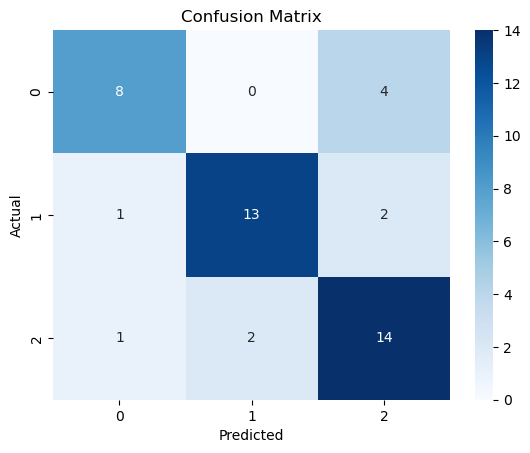

In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Optional: If you want a more visual representation, you can use Seaborn to create a heatmap.
# If you haven't installed seaborn, you can do so with 'pip install seaborn'
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Initialize a decision tree classifier
# You can specify parameters such as max_depth, min_samples_split, etc.
# - max_depth limits the number of nodes in the tree
# - min_samples_split represents the minimum number of samples required to split an internal node
# - criterion can be "gini" for the Gini impurity and "entropy" for the information gain
tree_clf = DecisionTreeClassifier(random_state=42)

# Train the classifier with the training data
tree_clf.fit(X_train, y_train)

# Predict the labels of the test data
y_pred = tree_clf.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 66.67%


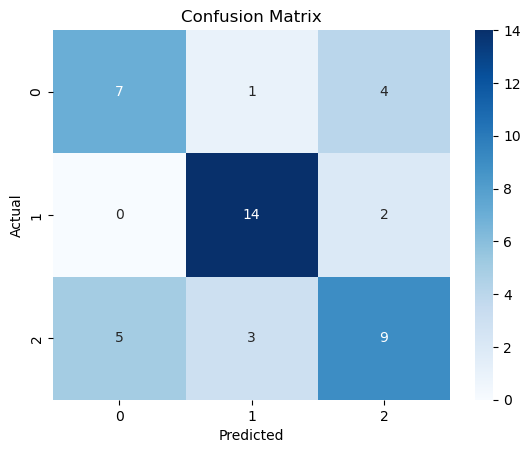

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Optional: If you want a more visual representation, you can use Seaborn to create a heatmap.
# If you haven't installed seaborn, you can do so with 'pip install seaborn'
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize an SVM classifier
# You can specify various parameters; common ones include:
# C: Regularization parameter. The strength of the regularization is inversely proportional to C.
# kernel: Specifies the kernel type to be used in the algorithm ('linear', 'poly', 'rbf', 'sigmoid', etc.)
# gamma: Kernel coefficient for 'rbf', 'poly', and 'sigmoid'. If gamma='scale' (default) is passed, then it uses 1 / (n_features * X.var()) as the value of gamma.
svm_clf = SVC(kernel='linear', random_state=42)

# Train the classifier with the training data
svm_clf.fit(X_train, y_train)

# Predict the labels of the test data
y_pred = svm_clf.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 55.56%


In [23]:
# Retrieve the weights of the features
svm_weights = np.abs(svm_clf.coef_)

# Normalize the weights
normalized_weights = svm_weights / np.linalg.norm(svm_weights)

# Optionally print the ranking of the features
for index, weight in enumerate(normalized_weights[0]):
    print(f"Feature {index + 1}: {weight:.2f}")

Feature 1: 0.00
Feature 2: 0.00
Feature 3: 0.00
Feature 4: 0.00
Feature 5: 0.00
Feature 6: 0.00
Feature 7: 0.00
Feature 8: 0.01
Feature 9: 0.00
Feature 10: 0.01
Feature 11: 0.00
Feature 12: 0.00
Feature 13: 0.00
Feature 14: 0.01
Feature 15: 0.00
Feature 16: 0.01
Feature 17: 0.00
Feature 18: 0.01
Feature 19: 0.01
Feature 20: 0.02
Feature 21: 0.02
Feature 22: 0.02
Feature 23: 0.02
Feature 24: 0.02
Feature 25: 0.02
Feature 26: 0.02
Feature 27: 0.02
Feature 28: 0.02
Feature 29: 0.02
Feature 30: 0.02
Feature 31: 0.02
Feature 32: 0.02
Feature 33: 0.02
Feature 34: 0.02
Feature 35: 0.02
Feature 36: 0.02
Feature 37: 0.02
Feature 38: 0.02
Feature 39: 0.02
Feature 40: 0.03
Feature 41: 0.04
Feature 42: 0.04
Feature 43: 0.04
Feature 44: 0.05
Feature 45: 0.04
Feature 46: 0.01
Feature 47: 0.01
Feature 48: 0.01
Feature 49: 0.01
Feature 50: 0.06
Feature 51: 0.07
Feature 52: 0.08
Feature 53: 0.09
Feature 54: 0.12
Feature 55: 0.00
Feature 56: 0.01
Feature 57: 0.00
Feature 58: 0.00
Feature 59: 0.07
Featur

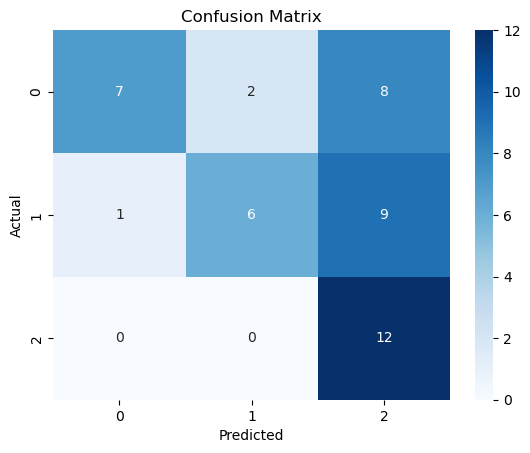

In [126]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Optional: If you want a more visual representation, you can use Seaborn to create a heatmap.
# If you haven't installed seaborn, you can do so with 'pip install seaborn'
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [127]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Initialize a KNeighborsClassifier
# 'n_neighbors' represents the number of neighbors to use for kneighbors queries.
knn_clf = KNeighborsClassifier(n_neighbors=3) # You can choose another number for n_neighbors

# Train the classifier with the training data
knn_clf.fit(X_train, y_train)

# Predict the labels of the test data
y_pred = knn_clf.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 62.22%


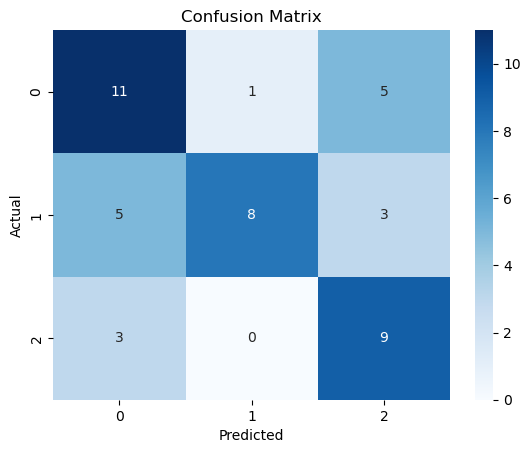

In [128]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Optional: If you want a more visual representation, you can use Seaborn to create a heatmap.
# If you haven't installed seaborn, you can do so with 'pip install seaborn'
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()